In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
import os
os.chdir('/content/drive/My Drive/Facial Emotion Recognition')
os.listdir()

['haarcascade_frontalface_default.xml',
 'trainfer.csv',
 'test.csv',
 'icml_face_data.csv',
 'sad.jpg',
 'fear.jpg',
 'disgust2.jpg',
 'disgust1.jpg',
 'surprise2.jpg',
 'surprise1.jpg',
 'neutral2.jpg',
 'neutral1.jpg',
 'happy2.jpg',
 'happy1.jpg',
 'surprise3.jpg',
 'angry.jpg',
 'fer2013weigths.h5',
 'fer2013.h5',
 'fer2013latest.h5']

In [ ]:
import pandas as pd
import tensorflow as tf

In [ ]:
train = pd.read_csv('icml_face_data.csv')
train.head()

,emotion,Usage,Unnamed: 2,pixels,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,...,Unnamed: 2266,Unnamed: 2267,Unnamed: 2268,Unnamed: 2269,Unnamed: 2270,Unnamed: 2271,Unnamed: 2272,Unnamed: 2273,Unnamed: 2274,Unnamed: 2275,Unnamed: 2276,Unnamed: 2277,Unnamed: 2278,Unnamed: 2279,Unnamed: 2280,Unnamed: 2281,Unnamed: 2282,Unnamed: 2283,Unnamed: 2284,Unnamed: 2285,Unnamed: 2286,Unnamed: 2287,Unnamed: 2288,Unnamed: 2289,Unnamed: 2290,Unnamed: 2291,Unnamed: 2292,Unnamed: 2293,Unnamed: 2294,Unnamed: 2295,Unnamed: 2296,Unnamed: 2297,Unnamed: 2298,Unnamed: 2299,Unnamed: 2300,Unnamed: 2301,Unnamed: 2302,Unnamed: 2303,Unnamed: 2304,Unnamed: 2305
0,0,Training,70,80,82,72,58,58,60,63,54,58,60,48,89,115,121,119,115,110,98,91,84,84,90,99,110,126,143,153,158,171,169,172,169,165,129,110,113,107,...,20,31,40,46,65,88,108,110,125,149,157,153,162,164,158,159,154,140,78,21,11,61,144,168,173,157,138,150,148,132,159,182,183,136,106,116,95,106,109,82
1,0,Training,151,150,147,155,148,133,111,140,170,174,182,154,153,164,173,178,185,185,189,187,186,193,194,185,183,186,180,173,166,161,147,133,172,151,114,161,161,146,...,150,129,143,135,115,102,111,124,112,109,132,146,135,149,148,143,163,156,159,150,139,128,116,125,133,109,130,147,130,121,105,108,95,108,102,67,171,193,183,184
2,2,Training,231,212,156,164,174,138,161,173,182,200,106,38,39,74,138,161,164,179,190,201,210,216,220,224,222,218,216,213,217,220,220,218,217,212,174,160,162,160,...,225,220,215,207,199,167,108,151,122,88,71,84,120,127,105,76,71,78,90,106,123,146,155,148,130,141,119,69,54,89,104,138,152,122,114,101,97,88,110,152
3,4,Training,24,32,36,30,32,23,19,20,30,41,21,22,32,34,21,19,43,52,13,26,40,59,65,12,20,63,99,98,98,111,75,62,41,73,118,140,192,186,...,124,150,161,167,169,167,162,164,169,181,172,168,169,170,174,179,180,182,196,208,226,230,140,113,114,125,135,141,172,214,174,126,132,132,133,136,139,142,143,142
4,6,Training,4,0,0,0,0,0,0,0,0,0,0,0,3,15,23,28,48,50,58,84,115,127,137,142,151,156,155,149,153,152,157,160,162,159,145,121,83,58,...,18,27,19,13,11,22,37,48,55,67,88,95,112,118,123,141,157,174,181,185,184,179,176,171,155,128,105,10,0,0,12,34,31,31,31,27,31,30,29,30


In [ ]:
test = pd.read_csv('trainfer.csv')
test.head()

,emotion,pixel 0,pixel 1,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,...,Unnamed: 2265,Unnamed: 2266,Unnamed: 2267,Unnamed: 2268,Unnamed: 2269,Unnamed: 2270,Unnamed: 2271,Unnamed: 2272,Unnamed: 2273,Unnamed: 2274,Unnamed: 2275,Unnamed: 2276,Unnamed: 2277,Unnamed: 2278,Unnamed: 2279,Unnamed: 2280,Unnamed: 2281,Unnamed: 2282,Unnamed: 2283,Unnamed: 2284,Unnamed: 2285,Unnamed: 2286,Unnamed: 2287,Unnamed: 2288,Unnamed: 2289,Unnamed: 2290,Unnamed: 2291,Unnamed: 2292,Unnamed: 2293,Unnamed: 2294,Unnamed: 2295,Unnamed: 2296,Unnamed: 2297,Unnamed: 2298,Unnamed: 2299,Unnamed: 2300,Unnamed: 2301,Unnamed: 2302,Unnamed: 2303,Unnamed: 2304
0,0,70,80,82,72,58,58,60,63,54,58,60,48,89,115,121,119,115,110,98,91,84,84,90,99,110,126,143,153,158,171,169,172,169,165,129,110,113,107,95,...,20,31,40,46,65,88,108,110,125,149,157,153,162,164,158,159,154,140,78,21,11,61,144,168,173,157,138,150,148,132,159,182,183,136,106,116,95,106,109,82
1,0,151,150,147,155,148,133,111,140,170,174,182,154,153,164,173,178,185,185,189,187,186,193,194,185,183,186,180,173,166,161,147,133,172,151,114,161,161,146,131,...,150,129,143,135,115,102,111,124,112,109,132,146,135,149,148,143,163,156,159,150,139,128,116,125,133,109,130,147,130,121,105,108,95,108,102,67,171,193,183,184
2,2,231,212,156,164,174,138,161,173,182,200,106,38,39,74,138,161,164,179,190,201,210,216,220,224,222,218,216,213,217,220,220,218,217,212,174,160,162,160,139,...,225,220,215,207,199,167,108,151,122,88,71,84,120,127,105,76,71,78,90,106,123,146,155,148,130,141,119,69,54,89,104,138,152,122,114,101,97,88,110,152
3,4,24,32,36,30,32,23,19,20,30,41,21,22,32,34,21,19,43,52,13,26,40,59,65,12,20,63,99,98,98,111,75,62,41,73,118,140,192,186,187,...,124,150,161,167,169,167,162,164,169,181,172,168,169,170,174,179,180,182,196,208,226,230,140,113,114,125,135,141,172,214,174,126,132,132,133,136,139,142,143,142
4,6,4,0,0,0,0,0,0,0,0,0,0,0,3,15,23,28,48,50,58,84,115,127,137,142,151,156,155,149,153,152,157,160,162,159,145,121,83,58,48,...,18,27,19,13,11,22,37,48,55,67,88,95,112,118,123,141,157,174,181,185,184,179,176,171,155,128,105,10,0,0,12,34,31,31,31,27,31,30,29,30


VISUALIZATION

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
train.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
emotion_labels = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

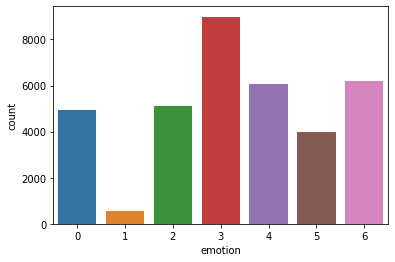

In [ ]:
sns.countplot(train.emotion)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


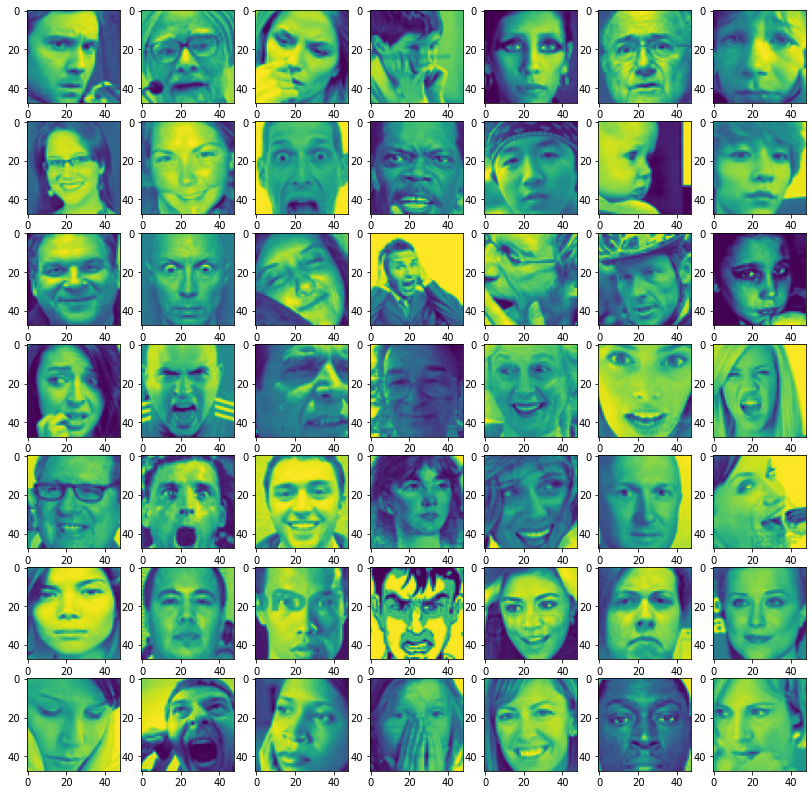

In [ ]:
fig = plt.figure(1, (14, 14))
for label in sorted(train.emotion.unique()):
  for i in range(1,50):
    fig.add_subplot(7, 7, i)
    plt.imshow(train.iloc[i-1:i,2:].values.reshape(48, 48))

PREPROCESSING

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
X = train.iloc[:,2:].values.astype('float32')
y = train['emotion'].values.astype('float32')

In [ ]:
num_classes = len(pd.unique(train['emotion']))
X = X.reshape(X.shape[0], 48, 48, 1)
y = tf.keras.utils.to_categorical(y, num_classes)

In [ ]:
X.shape, y.shape

((35887, 48, 48, 1), (35887, 7))

In [ ]:
def normalize(data):
  data /= 255
  return data

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((32298, 48, 48, 1), (32298, 7), (3589, 48, 48, 1), (3589, 7))

In [ ]:
X_train = normalize(X_train)
X_val = normalize(X_val)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.15,
    zoom_range=0.15,
    #rotation_range=15,
    #width_shift_range=0.15,
    #height_shift_range=0.15,
    horizontal_flip=True )

In [ ]:
def FER():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(64, (5,5), activation='elu', padding='same', input_shape=(48, 48, 1), kernel_initializer=tf.keras.initializers.he_normal()))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(64, (5,5), activation='elu', padding='same', kernel_initializer=tf.keras.initializers.he_normal()))
  #model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(0.4))
  
  model.add(tf.keras.layers.Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer=tf.keras.initializers.he_normal()))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(128, (3,3), activation='elu', padding='same', kernel_initializer=tf.keras.initializers.he_normal()))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer=tf.keras.initializers.he_normal()))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(256, (3,3), activation='elu', padding='same', kernel_initializer=tf.keras.initializers.he_normal()))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(0.5))

  # model.add(tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'))
  # model.add(tf.keras.layers.BatchNormalization())
  # model.add(tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'))
  # model.add(tf.keras.layers.BatchNormalization())
  # model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
  # model.add(tf.keras.layers.Dropout(0.5))
  
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.he_normal()))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.6))
  # model.add(tf.keras.layers.Dense(256, activation='relu'))
  # model.add(tf.keras.layers.Dropout(0.4))
  # model.add(tf.keras.layers.Dense(128, activation='relu'))
  # model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))  
  
  return model

In [ ]:
# callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.001)

In [ ]:
batch_size = 64
epochs = 150

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
fer_cnn = FER()
fer_cnn.compile(loss='categorical_crossentropy', 
                optimizer=tf.keras.optimizers.Adam(
                    learning_rate=0.001, 
                    beta_1=0.9, 
                    beta_2=0.999, 
                    epsilon=1e-07), 
                metrics=['accuracy'])

In [ ]:
datagen.fit(X_train)
# datagen.fit(X_val)
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
#valid_gen = datagen.flow(X_val, y_val)

In [ ]:
history = fer_cnn.fit_generator(train_gen, 
                                validation_data=(X_val, y_val), 
                                steps_per_epoch=len(X_train)/batch_size, 
                                epochs=epochs, 
                                verbose=1,
                                callbacks=callbacks)

Epoch 1/150
505/504 [==============================] - 14s 29ms/step - loss: 2.0248 - accuracy: 0.2839 - val_loss: 1.7925 - val_accuracy: 0.3388 - lr: 0.0010
Epoch 2/150
505/504 [==============================] - 14s 28ms/step - loss: 1.5391 - accuracy: 0.4085 - val_loss: 1.3642 - val_accuracy: 0.4823 - lr: 0.0010
Epoch 3/150
505/504 [==============================] - 14s 28ms/step - loss: 1.3822 - accuracy: 0.4731 - val_loss: 1.3344 - val_accuracy: 0.4909 - lr: 0.0010
Epoch 4/150
505/504 [==============================] - 14s 28ms/step - loss: 1.3037 - accuracy: 0.5062 - val_loss: 1.1669 - val_accuracy: 0.5578 - lr: 0.0010
Epoch 5/150
505/504 [==============================] - 14s 28ms/step - loss: 1.2444 - accuracy: 0.5324 - val_loss: 1.2111 - val_accuracy: 0.5308 - lr: 0.0010
Epoch 6/150
505/504 [==============================] - 14s 28ms/step - loss: 1.1999 - accuracy: 0.5496 - val_loss: 1.7402 - val_accuracy: 0.4865 - lr: 0.0010
Epoch 7/150
505/504 [==============================]

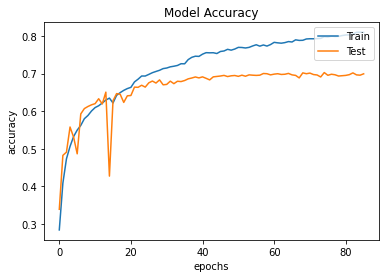

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'], loc = 'upper right')
plt.show()

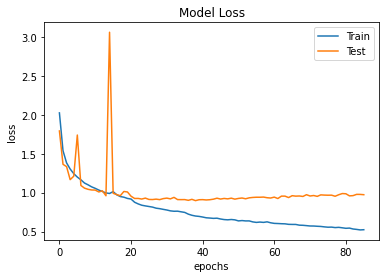

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Test'], loc = 'upper right')
plt.show()

In [ ]:
fer_cnn.save('fer2013val_acc:70.h5')

In [ ]:
#fer_cnn.save_weights('fer2013weigths.h5')